In [29]:
%matplotlib inline

# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
sns.set_style('whitegrid')
sns.set_context('talk')

# Eliminate false positive SettingWithCopyWarning
pd.options.mode.chained_assignment = None


np.random.seed(1234567890)
n_estimators=100

df = pd.read_csv('titanic.csv')

In [30]:
#переводим категориальные признаки в бинарные
df = df.join(pd.get_dummies(df['sex'], prefix = 'sex',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['embarked'], prefix = 'embarked',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['class'], prefix = 'class',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['who'], prefix = 'who',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['deck'], prefix = 'deck',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['embark_town'], prefix = 'embark_town',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['adult_male'], prefix = 'eadult_male',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['alive'], prefix = 'alive',  prefix_sep='_'), how = 'outer')
df = df.join(pd.get_dummies(df['alone'], prefix = 'alone',  prefix_sep='_'), how = 'outer')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,eadult_male_False,eadult_male_True,alive_no,alive_yes,alone_False,alone_True
0,0,3,male,22.0,1,0,7.2500,S,Third,man,...,0,0,0,1,0,1,1,0,1,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,...,0,1,0,0,1,0,0,1,1,0
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,...,0,0,0,1,1,0,0,1,0,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,...,0,0,0,1,1,0,0,1,1,0
4,0,3,male,35.0,0,0,8.0500,S,Third,man,...,0,0,0,1,0,1,1,0,0,1


In [31]:
#удаляем столбцы с категориальными признаками
df = df.drop(['sex'],1)
df = df.drop(['embarked'],1)
df = df.drop(['class'],1)
df = df.drop(['who'],1)
df = df.drop(['deck'],1)
df = df.drop(['embark_town'],1)
df = df.drop(['alive'],1)
df = df.drop(['alone'],1)
df = df.drop(['adult_male'],1)


In [32]:
variables = ['pclass', 'age', 'sibsp', 'parch', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman', 'deck_A', 'deck_B',
       'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G',
       'embark_town_Cherbourg', 'embark_town_Queenstown',
       'embark_town_Southampton', 'eadult_male_False', 'eadult_male_True',
       'alone_False', 'alone_True', 'fare']
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
subset = df[variables].dropna()
print(subset.shape)


(714, 30)


In [33]:
n_estimators=25

subset['ages'] = pd.cut(subset['age'], 3, labels=['0%-33%','34%-66%','67%-100%'])
subset['ages'] = subset['ages'].astype('category')

variables.pop(0)

predictors = subset[variables]
targets = subset['ages']

In [34]:
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.3)

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


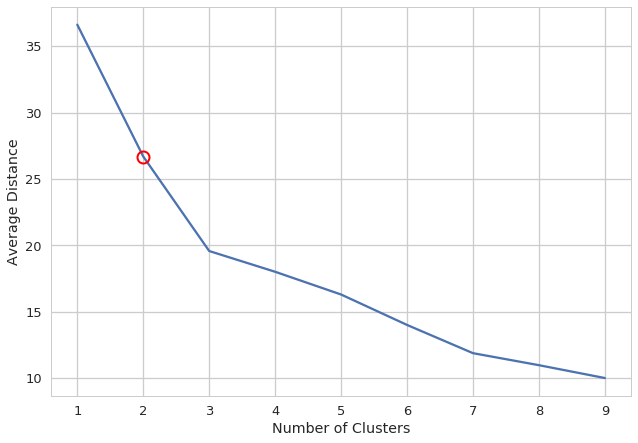

In [35]:
# Identify number of clusters using the elbow method
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(training_data)
    clusassign=model.predict(training_data)
    dist = sum(np.min(cdist(training_data, model.cluster_centers_, 'euclidean'), axis=1))
    meandist.append(dist / training_data.shape[0])

# Visualize the elbow
k = 2

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(clusters, meandist)
ax.plot(clusters[(k-1)], meandist[(k-1)], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.show()

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


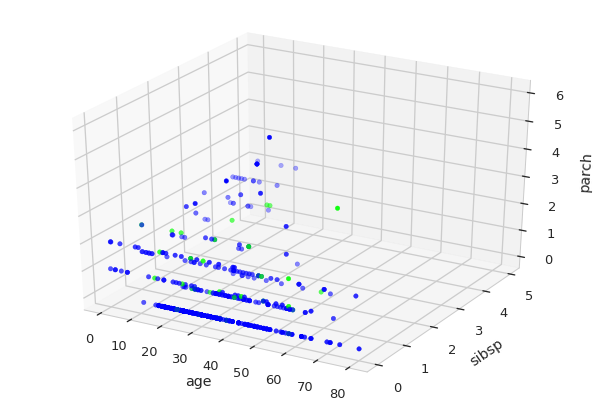

In [36]:

model=KMeans(n_clusters=k)
model.fit(training_data)
training_data['cluster'] = model.labels_
# Change Colors
my_cmap = plt.cm.get_cmap('brg')
my_cmap.set_under('w')

x = training_data.iloc[:,0]
y = training_data.iloc[:,1]
z = training_data.iloc[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=training_data['cluster'], cmap=my_cmap)
ax.set_xlabel(training_data.columns.values[0], labelpad=15)
ax.set_ylabel(training_data.columns.values[1], labelpad=15)
ax.set_zlabel(training_data.columns.values[2], labelpad=15)
plt.show()